#### BackGround
This task is based on a synthesised transaction dataset containing 3 months’ worth of transactions for 100 hypothetical customers. It contains purchases, recurring transactions, and salary transactions.

The dataset is designed to simulate realistic transaction behaviours that are observed in ANZ’s real transaction data, so many of the insights you can gather from the tasks below will be genuine.

#### Questions
Start by doing some basic checks – are there any data issues? Does the data need to be cleaned?

Gather some interesting overall insights about the data. For example -- what is the average transaction amount? How many transactions do customers make each month, on average?

Segment the dataset by transaction date and time. Visualise transaction volume and spending over the course of an average day or week. Consider the effect of any outliers that may distort your analysis.

For a challenge – what insights can you draw from the location information provided in the dataset?

#### data explantaion:
- status: transaction status
 - authorized: bank has verified that request is henuine and authentic
 - posted: the transaction has been updated in the appropriate ledger of the bank.
 
- card_present_flag: a card not present(CNP) transaction is a paymentcard transaction made where the cardholder does ot or present physically present the card for a merchant's visual examination at the time that an order is given and payment effected. (eg. It’s most common for orders that happen remotely — online purchases, phone orders, recurring payments, online invoices ...)
 - 1: the cards were with the customers while they were doing their transaction.
 - 0: the cards were not with the customers during the transaction

- bpay_biller_code: BPAY is an electronic bill payment system in Australia which enables's online, mobile or telephone bankng facility to organisations which are registered BPAY billers. There are majority of entries (11158 entries) with the missing bpay_biller_code.

- account: unique account number as customer_id 

- currency: currency type (Australian dollar - AUD)

- long_lat: customer location longtitue and latitude, splited by two new columns customer_log, customer_lat.

- txn_description: which way the transaction occured. ways: SALES-POS, POS, PAYMENT, PAY/SALARY, INTER BANK, PHONE BANK.

- merchant_id: 5725 unique merchant_id

- merchant_code: a fout-digit number listed in ISO 18245 for retail financial services. 11160 entries of missing merchant_code. The summary of the merchant_code shows that either the merchant is 0, which is not possible, or this information is missing. Because of these reasons, the column will not be used in the next steps.

- first_name: customer's foirst name

- balance: account balance

- date: the data when the transaction occurs

- gender: customer's gender

- age: customer's age

- merchant_suburb: where the transaction occured as in surburbs

- merchant_state: where the transaction occured as in state

- exrtaction: the datetime(hms) when the transactoin occurs

- amount: the amount money costumer spend in the transaction

- transaction_id: unique transaction id

- country: the transactoin occurs as in country

- customer_id: unique customer id as account number

- merchant_long_lat: the location of merchant, splited as two columns 'merchant_long' and 'merchant_lat'

- movement: type of the account as debit card or credit card

The dataset contains 12043 transactions for 100 customers who have one bank account each. Trasaction period is from 2018-08-01 to 2018-10-31 (92 days). 
The data entries are unique and have consistent formats for analysis. 
There sre some pattern of missing values, due to nature of the transaction. (eg, merchants info are not involved for InterBank transfers or Salary payments.) 

In [67]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import missingno as msno 
from geopy.geocoders import Nominatim
import seaborn as sns

In [118]:
raw_data = pd.read_excel('data/ANZ synthesised transaction dataset.xlsx', header = 0)


In [119]:
df = raw_data.copy()

In [120]:
df.columns

Index(['status', 'card_present_flag', 'bpay_biller_code', 'account',
       'currency', 'long_lat', 'txn_description', 'merchant_id',
       'merchant_code', 'first_name', 'balance', 'date', 'gender', 'age',
       'merchant_suburb', 'merchant_state', 'extraction', 'amount',
       'transaction_id', 'country', 'customer_id', 'merchant_long_lat',
       'movement'],
      dtype='object')

In [121]:
df.shape


(12043, 23)

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12043 entries, 0 to 12042
Data columns (total 23 columns):
status               12043 non-null object
card_present_flag    7717 non-null float64
bpay_biller_code     885 non-null object
account              12043 non-null object
currency             12043 non-null object
long_lat             12043 non-null object
txn_description      12043 non-null object
merchant_id          7717 non-null object
merchant_code        883 non-null float64
first_name           12043 non-null object
balance              12043 non-null float64
date                 12043 non-null datetime64[ns]
gender               12043 non-null object
age                  12043 non-null int64
merchant_suburb      7717 non-null object
merchant_state       7717 non-null object
extraction           12043 non-null object
amount               12043 non-null float64
transaction_id       12043 non-null object
country              12043 non-null object
customer_id          12043 n

### Data Wrangling
1. when the tranactions status is recored as authorized, the txn_description could only be SALES-POS and POS. And when the transactions staus is posted, the txn_description are the PAYMENT, PAY/SALARY, INTER BANK and PHIONE BANK. 

2. `bpay_biller_code`: BPAY is an electronic bill payment system in Australia which enables's online, mobile or telephone bankng facility to organisations which are registered BPAY billers Among the whole dataset, there are only two transactions went through the BPAY system. There are THE DISCOUNT CHEMIST GROUP and LAND WATER & PLANNING East Melbourne. I convert all the 0 values to NaN

3. `merchant_code`: These columns only contain NaN and 0 value. (we could drop the columns ? )

4. The four features, `card_present_flag`, `merchant_id`, `merchant_suburb`, `merchant_state`, `merchant_long_lat`, have the same pattern of missingness in the dataset. When the `card_present_flag` is not recorded, eg, the transaction through the third party vendor, the infomation of the merchant would not be recorded as well. Only 64% of data have these values.

5. Since `merchant_long_lat` have the longtitude and latitude, we need to split them `merchant_long` and `merchant_lat`. `long_lat` have the customer lonmgtidue and latitude, we need to split them `customer_long` and `customer_lat`

6. convert extraction to datetime type

7. the dataset have 92 days range ('2018-10-31', '2018-08-01'), the data contains records for 91 days, so one day is missing. 2018-08-16 is missing

8. `first_name`: there are 100 unique customers and 80 unique first names, so some customers share same first name. So we add postfix to the same first name

9. the customer location of Daniel is wrong

10. extract the customer terriroty

11. add age group

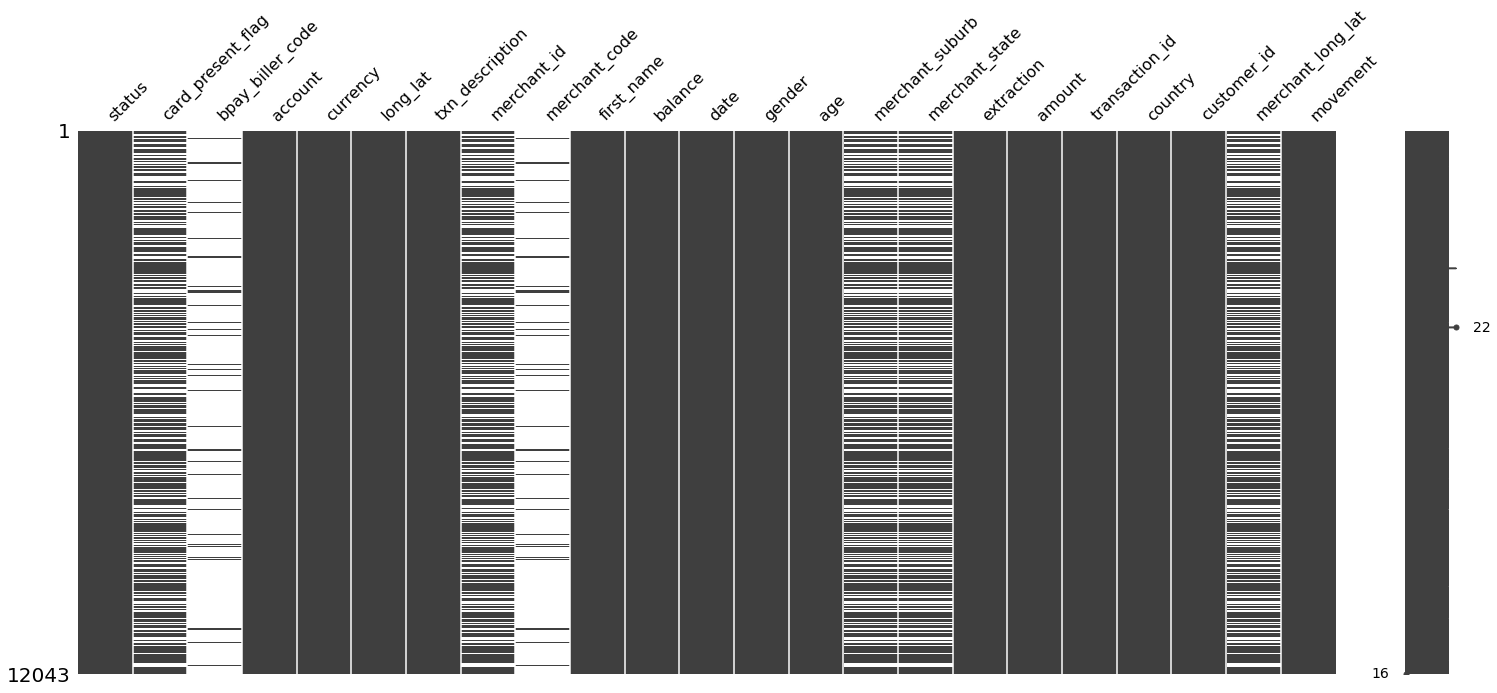

In [123]:
msno.matrix(df)


In [124]:
# 1
df.groupby(df.status).txn_description.value_counts()

status      txn_description
authorized  SALES-POS          3934
            POS                3783
posted      PAYMENT            2600
            PAY/SALARY          883
            INTER BANK          742
            PHONE BANK          101
Name: txn_description, dtype: int64

In [125]:
# 2
df['bpay_biller_code'] = df['bpay_biller_code'].replace(0, np.nan)
df.bpay_biller_code.value_counts()

 LAND WATER & PLANNING East Melbourne    1
 THE DISCOUNT CHEMIST GROUP              1
Name: bpay_biller_code, dtype: int64

In [126]:
# 3
# df.merchant_code.describe()
df.drop(['merchant_code'], axis = 1, inplace = True)

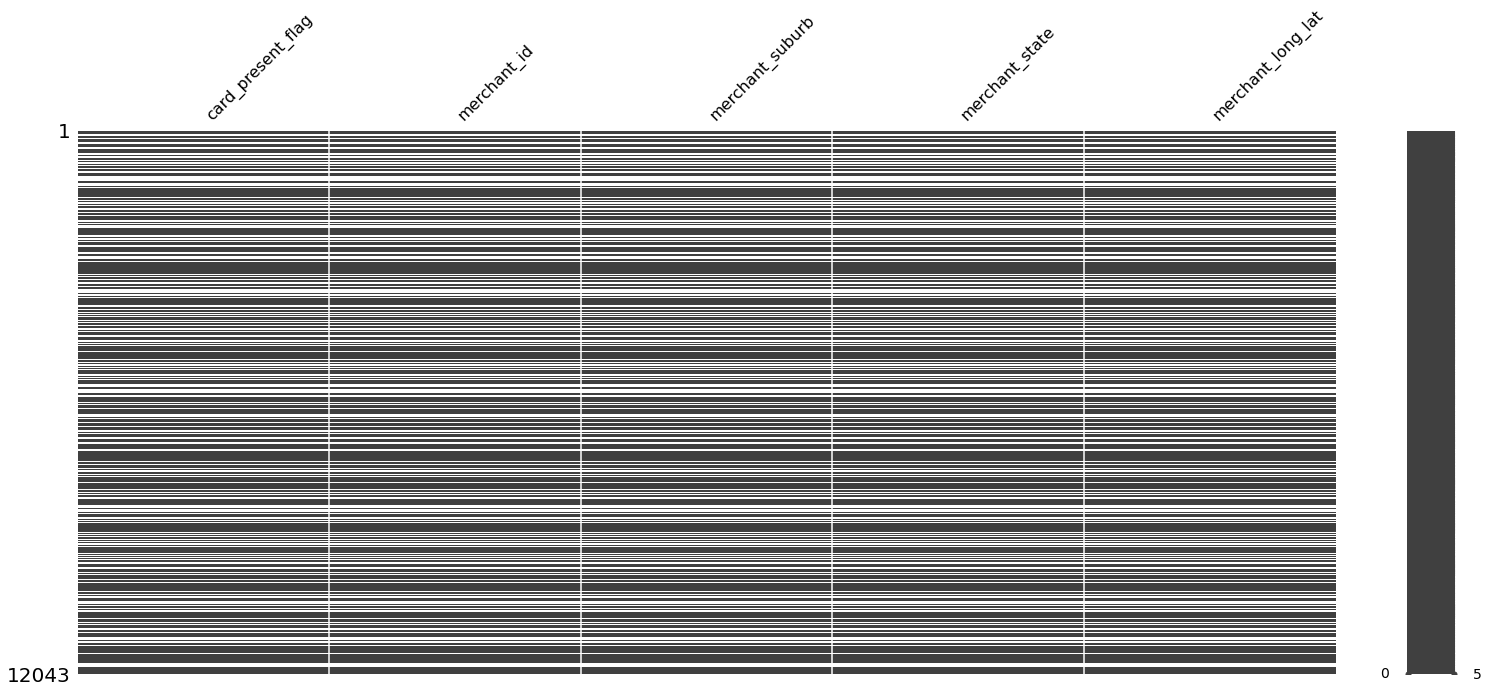

In [127]:
# 4
msno.matrix(df[['card_present_flag', 'merchant_id', 'merchant_suburb', 'merchant_state', 'merchant_long_lat']])

In [128]:
# 5
def converter_long(x):
    try: 
        return float(x.split()[0])
    except AttributeError:
        return np.nan
    

def converter_lat(x):
    try:
        return float(x.split()[1])
    except AttributeError:
        return np.nan
    


    


In [129]:
df['customer_long'] = df.long_lat.apply(converter_long)
df['customer_lat'] = df.long_lat.apply(converter_lat)
df.drop(['long_lat'], axis = 1, inplace = True)


df['merchant_long'] = df.merchant_long_lat.apply(converter_long)
df['merchant_lat'] = df.merchant_long_lat.apply(converter_lat)
df.drop(['merchant_long_lat'], axis = 1, inplace = True)

In [130]:
# 6 
df.extraction = pd.to_datetime(df.extraction)

In [131]:
# 7
# the dataset have 92 days range ('2018-10-31', '2018-08-01')
# the data contains records for 91 days, so one day is missing
# delta = max(df.date) - min(df.date)
print('total records for days', df.date.nunique())
date_range = np.arange(min(df.date), max(df.date) + timedelta(days = 1), timedelta(days = 1))
date_range = pd.to_datetime(date_range)

# the set of date in dataset
df_date_set = set(df.date)
# the set of date range from 2018-08-01 to 2018-10-31
date_range_set = set(date_range)
# check which day is missing
#(A==B).all()
date_range_set
date_range_set.difference(df_date_set)
# 2018-08-16 is missing

total records for days 91


{Timestamp('2018-08-16 00:00:00')}

In [132]:
# 8
#print('the number of differnet first names', df.first_name.nunique(), 'the number of accounts', df.account.nunique())

multi_account_same_firstname = df.groupby(df.first_name)\
.agg({'account': 'nunique'})\
.sort_values(by = 'account', ascending = False)\
.head(14)\
.reset_index()

def make_table_same_firstname_extract_account(firstname):
    '''
    makeing a table to show different account mapping to the same first name and extract the differnt account
    param: 
      firstname: the string of the first name
    return:
      the series of accounts for having the same first name.
    '''
    rowindex_first_name = df['first_name'] == firstname
    table = df[rowindex_first_name].groupby('account', as_index = False)['first_name']
    return table.first()['account']

firstname_dict = {}
for i in range(len(multi_account_same_firstname.first_name)):
    firstname_dict[multi_account_same_firstname.first_name[i]] = make_table_same_firstname_extract_account(multi_account_same_firstname.first_name[i]).to_list()
# print(firstname_dict)

def add_postfix(firstname):
    '''
    looping the firstname_dict, add the postfix to the firstname when then same firstname has multi account.
    Params:
      firstname: the string of the first name
    Return:
      adding the postfix to firstname in the dataset.
    '''
    column_name = 'first_name'
    
    for i in range(len(firstname_dict[firstname])):
        mask = df.account == firstname_dict[firstname][i]
        df.loc[mask, column_name] = firstname + '_' + str(i)
        
for key in firstname_dict.keys():
    add_postfix(key)
    


In [133]:
# 9
df[df.first_name == 'Daniel'][['customer_long', 'customer_lat']].head(1)

,customer_long,customer_lat
47,255.0,-573.0


In [134]:
assert df.first_name.nunique() == df.account.nunique() == df.customer_id.nunique()
assert df.groupby('first_name')['customer_long'].nunique().all() == 1
assert df.groupby('first_name')['customer_lat'].nunique().all() == 1

In [135]:
# 10

geolocator = Nominatim(user_agent="ANZ_customer_location")
def get_city(lat, long):
    if (-90 <= lat <= 90) & (-180 <= long <= 180):
        temp_lat = str(lat)
        temp_long = str(long)
        location = geolocator.reverse(temp_lat+","+temp_long)
        if 'city' in location.raw['address']:
            return location.raw['address']['city']
        elif 'town' in location.raw['address']:
            return location.raw['address']['town']
        else:
            return location.raw['address']['municipality']
    else:
        return np.nan

def get_state(lat, long):
    if (-90 <= lat <= 90) & (-180 <= long <= 180):
        temp_lat = str(lat)
        temp_long = str(long)
        location = geolocator.reverse(temp_lat+","+temp_long)
        if 'state' in location.raw['address']:
            return location.raw['address']['state']
        else:
            return location.raw['address']['territory']
    else:
        return np.nan

In [136]:
customer = df[['account', 'first_name', 'gender', 'age', 'customer_long', 'customer_lat']]\
.drop_duplicates()\
.reset_index(drop=True)

customer['customer_state'] = customer\
.apply(lambda x: get_state(x['customer_lat'], x['customer_long']), axis = 1)


In [137]:
df = pd.merge(df, 
         customer[['account', 'customer_state']], 
         how = 'left',
         on = 'account')

In [138]:
# 11

df['age_group'] = pd.cut(df["age"], bins=[10,20,30,40,50,60,70,80],
       labels = ['11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80'])

In [139]:
df_clean = df.copy()
df_clean.to_csv('data/df_clean.csv', index = False)

### EDA

1. what is the average transaction amount? How many transactions do customers make each month, on average?

2. Segment the dataset by transaction date and time. Visualise transaction volume and spending over the course of an average day or week. Consider the effect of any outliers that may distort your analysis.

3. what insights can you draw from the location information provided in the dataset?


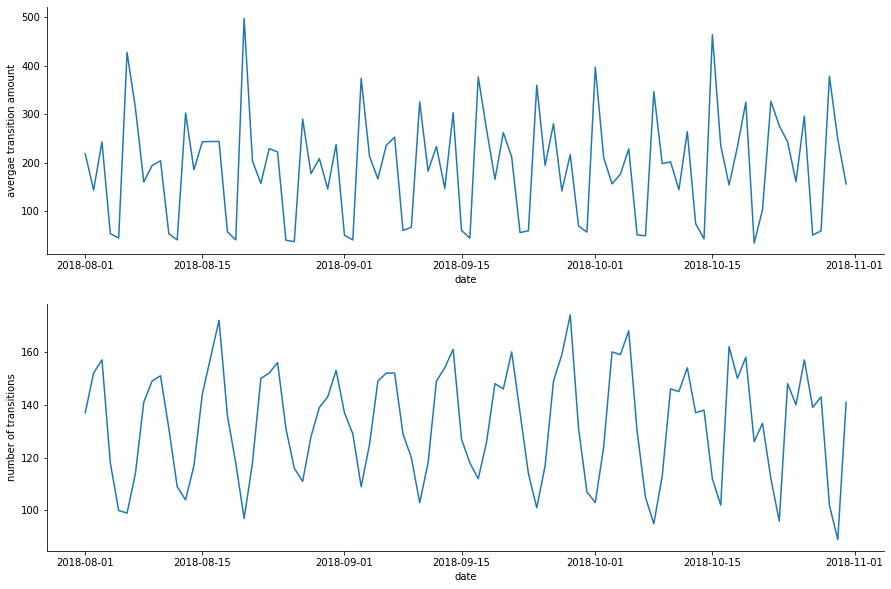

In [140]:
# by date
temp = df_clean.groupby('date').amount.agg(['mean', 'count']).reset_index()
plt.figure(figsize = (15, 10))
plt.subplot(211)
sns.lineplot(x = 'date', y='mean', data=temp);
plt.ylabel('avergae transition amount')
sns.despine();
plt.subplot(212)
sns.lineplot(x = 'date', y='count', data=temp);
plt.ylabel('number of transitions')
sns.despine();

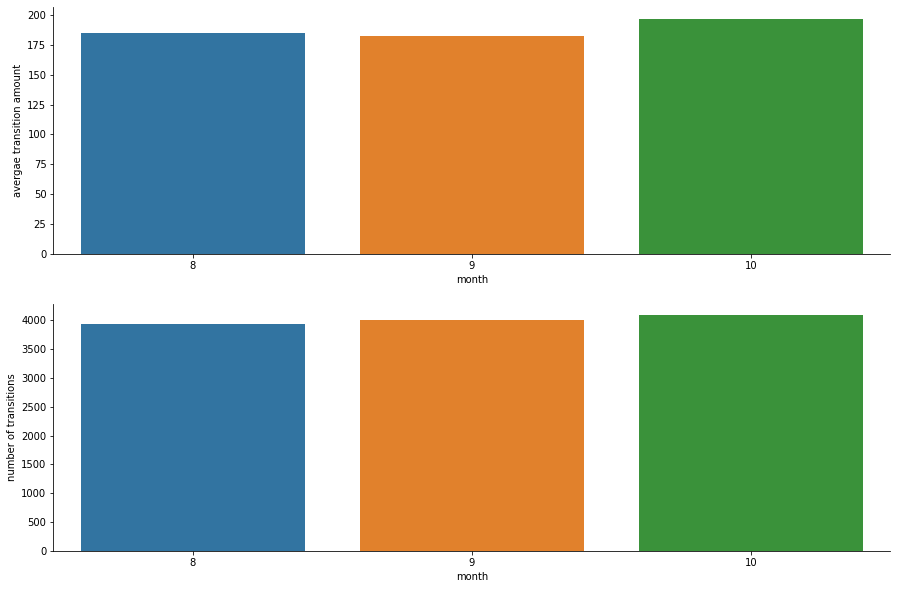

In [141]:
# by month
temp = df_clean.groupby(df.extraction.dt.month).amount.agg(['mean', 'count']).reset_index()
plt.figure(figsize = (15, 10))
plt.subplot(211)
sns.barplot(x = 'extraction', y='mean', data=temp);
plt.ylabel('avergae transition amount')
plt.xlabel('month')
sns.despine();
plt.subplot(212)
sns.barplot(x = 'extraction', y='count', data=temp);
plt.ylabel('number of transitions')
plt.xlabel('month')
sns.despine();

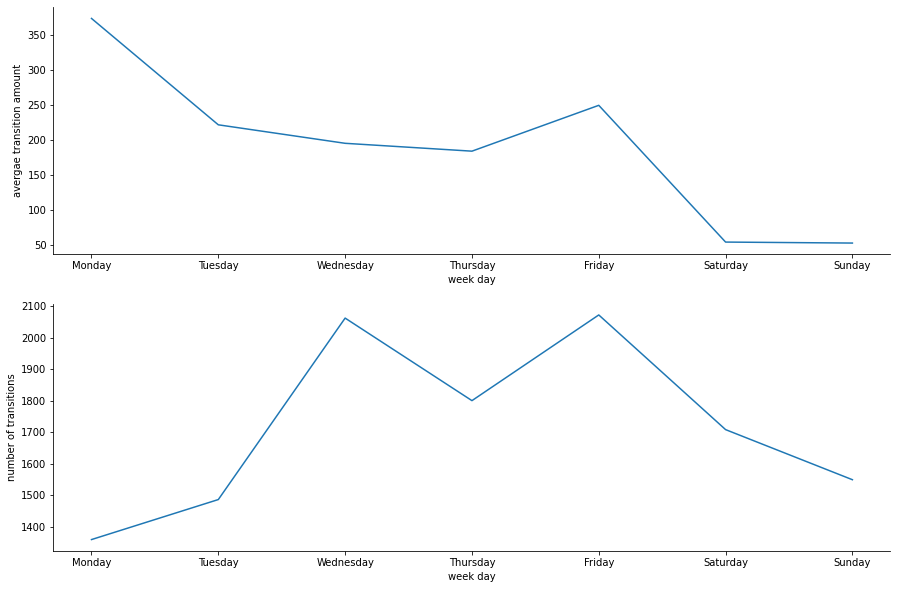

In [142]:
# by weekday

temp = df_clean\
.groupby(df.extraction.dt.weekday_name)\
.amount\
.agg(['mean', 'count'])\
.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])\
.reset_index()

plt.figure(figsize = (15, 10))
plt.subplot(211)
sns.lineplot(x = 'extraction', y='mean', data=temp);
plt.ylabel('avergae transition amount')
plt.xlabel('week day')
sns.despine();
plt.subplot(212)
sns.lineplot(x = 'extraction', y='count', data=temp);
plt.ylabel('number of transitions')
plt.xlabel('week day')
sns.despine();

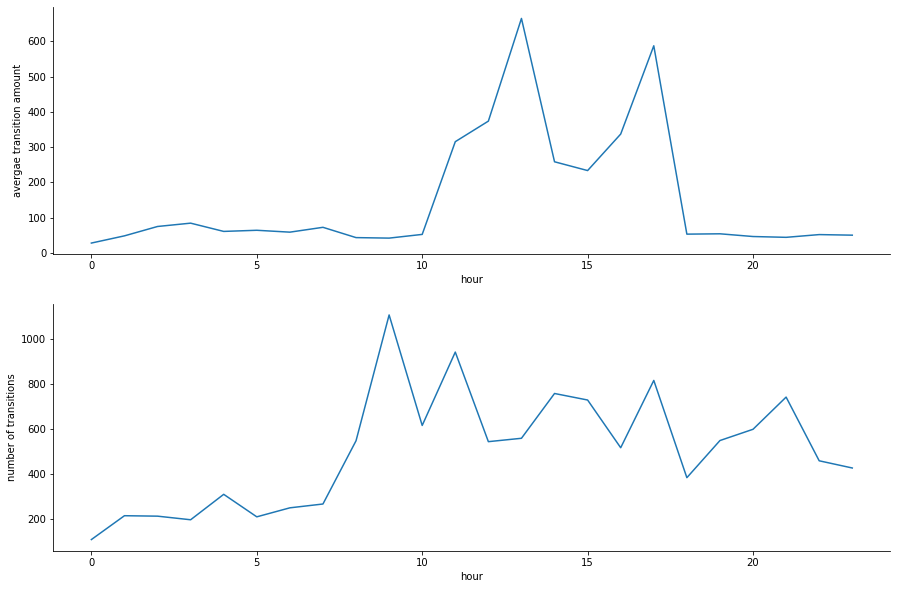

In [143]:
# by hour
temp = df_clean\
.groupby(df.extraction.dt.hour)\
.amount\
.agg(['mean', 'count'])\
.reset_index()

plt.figure(figsize = (15, 10))
plt.subplot(211)
sns.lineplot(x = 'extraction', y='mean', data=temp);
plt.ylabel('avergae transition amount')
plt.xlabel('hour')
sns.despine();
plt.subplot(212)
sns.lineplot(x = 'extraction', y='count', data=temp);
plt.ylabel('number of transitions')
plt.xlabel('hour')
sns.despine();

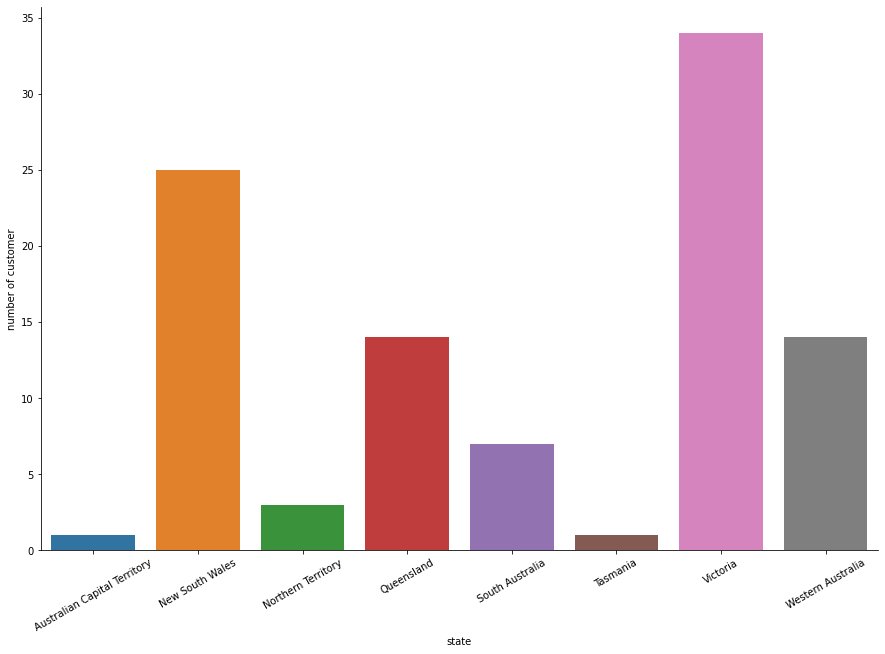

In [147]:
# by state
temp = df.groupby('customer_state')['account'].nunique().reset_index()
plt.figure(figsize = (15, 10))
sns.barplot(x = 'customer_state', y='account', data = temp);
plt.xticks(rotation = 30)
plt.ylabel('number of customer')
plt.xlabel('state')
sns.despine();